In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor



In [2]:
df1 = pd.read_csv('whitney_sleep_data.csv')
df2 = pd.read_csv('whitney_sleep_data_2.csv')
df3 = pd.read_csv('whitney_sleep_data_3.csv')
df4 = pd.read_csv('whitney_sleep_data_4.csv')

In [3]:
combined_df = pd.concat([df1, df2, df3, df4], axis=0)

combined_df.reset_index(drop=True, inplace=True)

In [4]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               400 non-null    int64  
 1   date                     400 non-null    object 
 2   duration_ms              400 non-null    int64  
 3   efficiency               400 non-null    int64  
 4   start_time               400 non-null    object 
 5   end_time                 400 non-null    object 
 6   time_in_bed              400 non-null    int64  
 7   minutes_asleep           400 non-null    int64  
 8   minutesToFallAsleep      400 non-null    int64  
 9   minutes_awake            400 non-null    int64  
 10  log_id                   400 non-null    int64  
 11  info_code                400 non-null    int64  
 12  IsMainSleep              400 non-null    bool   
 13  deep_sleep_count         368 non-null    float64
 14  deep_sleep_minutes       3

In [5]:
combined_df = combined_df.dropna()

In [6]:
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df['date'] = combined_df['date'].dt.date

In [7]:
combined_df['date'].min()

datetime.date(2023, 2, 21)

In [8]:
combined_df['date'].max()

datetime.date(2024, 2, 19)

In [9]:
activity_entries = pd.read_csv('Whitney_activity_entries.csv')

In [10]:
activity_entries['start_time'].min()

'2023-03-24T18:35:44.000-04:00'

In [11]:
activity_entries['start_time'].max()

'2024-02-14T07:21:45.000-06:00'

In [12]:
len(activity_entries)

86

In [13]:
# Aggregate steps to find total steps for each day across all activiites
# Aggregate total calorie burn for each day

# Only pull duration for each activity type to allow more easy seperation of each activity type

# Once all of this is organized, merge to the sleep data on the Date column

activity_entries.head()

,Unnamed: 0,activeDuration,activity_type,activity_id,avg_hr,calorie_burn,duration,original_duration,start_time,steps,total_minutes_for_activity,logId
0,0,921000,Sport,15000,91,41,921000,921000,2023-03-24T18:35:44.000-04:00,231,0,54655710797
1,1,1229000,Sport,15000,113,106,1229000,1229000,2023-04-02T19:12:13.000-04:00,1674,7,54851970100
2,2,3482000,Walk,90013,117,344,3482000,3482000,2023-04-15T11:28:43.000-04:00,5325,30,55124576266
3,3,973000,Walk,90013,113,88,973000,973000,2023-05-05T20:17:14.000-05:00,1283,6,55592808773
4,4,921000,Walk,90013,115,86,921000,921000,2023-05-09T08:58:25.000-04:00,1435,8,55675716016


In [14]:
activity_entries['start_time'] = activity_entries['start_time'].str.split('T').str.get(0)


In [15]:
activity_entries['start_time']

0     2023-03-24
1     2023-04-02
2     2023-04-15
3     2023-05-05
4     2023-05-09
         ...    
81    2024-02-08
82    2024-02-10
83    2024-02-11
84    2024-02-13
85    2024-02-14
Name: start_time, Length: 86, dtype: object

In [16]:
activity_entries = activity_entries[activity_entries['total_minutes_for_activity'] > 0]

In [17]:
len(activity_entries)

77

In [18]:
activity_entries['start_time'].nunique() 

75

In [19]:
activity_entries.head()

,Unnamed: 0,activeDuration,activity_type,activity_id,avg_hr,calorie_burn,duration,original_duration,start_time,steps,total_minutes_for_activity,logId
1,1,1229000,Sport,15000,113,106,1229000,1229000,2023-04-02,1674,7,54851970100
2,2,3482000,Walk,90013,117,344,3482000,3482000,2023-04-15,5325,30,55124576266
3,3,973000,Walk,90013,113,88,973000,973000,2023-05-05,1283,6,55592808773
4,4,921000,Walk,90013,115,86,921000,921000,2023-05-09,1435,8,55675716016
5,5,973000,Walk,90013,112,86,973000,973000,2023-05-15,1351,7,55842154404


In [20]:
activity_entries['start_time'] = pd.to_datetime(activity_entries['start_time'])
activity_entries['date'] = activity_entries['start_time'].dt.date



In [21]:
pivot_calories = activity_entries.pivot_table(values='calorie_burn', index='date', columns='activity_type', aggfunc='sum', fill_value=0)
pivot_duration = activity_entries.pivot_table(values='original_duration', index='date', columns='activity_type', aggfunc='sum', fill_value=0)


In [22]:
pivot_calories.columns = [f"{col}_calorie_burn" for col in pivot_calories.columns]
pivot_duration.columns = [f"{col}_original_duration" for col in pivot_duration.columns]


In [23]:
combined_pivot = pivot_calories.join(pivot_duration)
combined_pivot.reset_index(inplace=True)
print(combined_pivot)

          date  Aerobic Workout_calorie_burn  Elliptical_calorie_burn  \
0   2023-04-02                             0                        0   
1   2023-04-15                             0                        0   
2   2023-05-05                             0                        0   
3   2023-05-09                             0                        0   
4   2023-05-15                             0                        0   
..         ...                           ...                      ...   
70  2024-02-07                             0                        0   
71  2024-02-08                             0                        0   
72  2024-02-10                             0                        0   
73  2024-02-13                             0                        0   
74  2024-02-14                             0                        0   

    Run_calorie_burn  Sport_calorie_burn  Walk_calorie_burn  \
0                  0                 106                  0 

In [24]:
activity_df = pd.DataFrame(combined_pivot)

In [25]:
activity_df.head()

,date,Aerobic Workout_calorie_burn,Elliptical_calorie_burn,Run_calorie_burn,Sport_calorie_burn,Walk_calorie_burn,Aerobic Workout_original_duration,Elliptical_original_duration,Run_original_duration,Sport_original_duration,Walk_original_duration
0,2023-04-02,0,0,0,106,0,0,0,0,1229000,0
1,2023-04-15,0,0,0,0,344,0,0,0,0,3482000
2,2023-05-05,0,0,0,0,88,0,0,0,0,973000
3,2023-05-09,0,0,0,0,86,0,0,0,0,921000
4,2023-05-15,0,0,0,0,86,0,0,0,0,973000


In [26]:
merged_df = pd.merge(combined_df,activity_df, on='date',how="left")

In [27]:
merged_df.head()

,Unnamed: 0,date,duration_ms,efficiency,start_time,end_time,time_in_bed,minutes_asleep,minutesToFallAsleep,minutes_awake,...,Aerobic Workout_calorie_burn,Elliptical_calorie_burn,Run_calorie_burn,Sport_calorie_burn,Walk_calorie_burn,Aerobic Workout_original_duration,Elliptical_original_duration,Run_original_duration,Sport_original_duration,Walk_original_duration
0,0,2023-02-21,32100000,94,2023-02-20T22:48:30.000,2023-02-21T07:44:00.000,535,477,0,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2023-02-22,29340000,96,2023-02-22T00:22:30.000,2023-02-22T08:31:30.000,489,424,0,65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2023-02-23,25980000,94,2023-02-22T23:47:30.000,2023-02-23T07:00:30.000,433,361,0,72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2023-02-24,35640000,95,2023-02-23T21:31:30.000,2023-02-24T07:25:30.000,594,508,0,86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2023-02-25,24720000,95,2023-02-25T01:22:30.000,2023-02-25T08:15:00.000,412,346,0,66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368 entries, 0 to 367
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         368 non-null    int64  
 1   date                               368 non-null    object 
 2   duration_ms                        368 non-null    int64  
 3   efficiency                         368 non-null    int64  
 4   start_time                         368 non-null    object 
 5   end_time                           368 non-null    object 
 6   time_in_bed                        368 non-null    int64  
 7   minutes_asleep                     368 non-null    int64  
 8   minutesToFallAsleep                368 non-null    int64  
 9   minutes_awake                      368 non-null    int64  
 10  log_id                             368 non-null    int64  
 11  info_code                          368 non-null    int64  

In [29]:
is_nap = merged_df['IsMainSleep'] == False

In [30]:
merged_df['is_nap'] = is_nap

In [31]:
merged_df.drop(columns=['Unnamed: 0','log_id','info_code','duration_ms'],axis=1,inplace=True)

In [32]:
merged_df['start_time'] = pd.to_datetime(merged_df['start_time'])
merged_df['end_time'] = pd.to_datetime(merged_df['end_time'])


In [33]:
merged_df['start_time'] = merged_df['start_time'].dt.strftime('%H:%M')
merged_df['end_time'] = merged_df['end_time'].dt.strftime('%H:%M')

In [34]:
pd.set_option('display.max_columns', 100)

In [35]:
merged_df['date'].nunique()

362

In [36]:
len(merged_df['date'])

368

In [37]:
merged_df.head()

,date,efficiency,start_time,end_time,time_in_bed,minutes_asleep,minutesToFallAsleep,minutes_awake,IsMainSleep,deep_sleep_count,deep_sleep_minutes,deep_sleep_30dayAvgMin,light_sleep_count,light_sleep_minutes,light_sleep_30dayAvgMin,rem_sleep_count,rem_sleep_minutes,rem_sleep_30dayAvgMin,wake_count,wake_minutes,wake_30dayAvgMin,Aerobic Workout_calorie_burn,Elliptical_calorie_burn,Run_calorie_burn,Sport_calorie_burn,Walk_calorie_burn,Aerobic Workout_original_duration,Elliptical_original_duration,Run_original_duration,Sport_original_duration,Walk_original_duration,is_nap
0,2023-02-21,94,22:48,07:44,535,477,0,58,True,7.0,123.0,0.0,27.0,255.0,0.0,9.0,99.0,0.0,27.0,58.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2023-02-22,96,00:22,08:31,489,424,0,65,True,4.0,65.0,123.0,28.0,282.0,255.0,8.0,77.0,99.0,26.0,65.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2023-02-23,94,23:47,07:00,433,361,0,72,True,5.0,98.0,94.0,20.0,166.0,269.0,6.0,97.0,88.0,20.0,72.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,2023-02-24,95,21:31,07:25,594,508,0,86,True,5.0,93.0,95.0,37.0,345.0,234.0,7.0,70.0,91.0,31.0,86.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,2023-02-25,95,01:22,08:15,412,346,0,66,True,3.0,82.0,95.0,30.0,218.0,262.0,5.0,46.0,86.0,30.0,66.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [38]:
merged_df['IsMainSleep'] = merged_df['IsMainSleep'].map({False:0,True:1})

merged_df['is_nap'] = merged_df['is_nap'].map({False:0,True:1})

In [39]:
merged_df['start_time'] = pd.to_datetime(merged_df['start_time'])
merged_df['end_time'] = pd.to_datetime(merged_df['end_time'])

merged_df['start_time'] = (merged_df['start_time'].dt.hour * 60) + (merged_df['start_time'].dt.minute)
merged_df['end_time'] = (merged_df['end_time'].dt.hour * 60) + (merged_df['end_time'].dt.minute)

In [40]:
merged_df.head()

,date,efficiency,start_time,end_time,time_in_bed,minutes_asleep,minutesToFallAsleep,minutes_awake,IsMainSleep,deep_sleep_count,deep_sleep_minutes,deep_sleep_30dayAvgMin,light_sleep_count,light_sleep_minutes,light_sleep_30dayAvgMin,rem_sleep_count,rem_sleep_minutes,rem_sleep_30dayAvgMin,wake_count,wake_minutes,wake_30dayAvgMin,Aerobic Workout_calorie_burn,Elliptical_calorie_burn,Run_calorie_burn,Sport_calorie_burn,Walk_calorie_burn,Aerobic Workout_original_duration,Elliptical_original_duration,Run_original_duration,Sport_original_duration,Walk_original_duration,is_nap
0,2023-02-21,94,1368,464,535,477,0,58,1,7.0,123.0,0.0,27.0,255.0,0.0,9.0,99.0,0.0,27.0,58.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2023-02-22,96,22,511,489,424,0,65,1,4.0,65.0,123.0,28.0,282.0,255.0,8.0,77.0,99.0,26.0,65.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2023-02-23,94,1427,420,433,361,0,72,1,5.0,98.0,94.0,20.0,166.0,269.0,6.0,97.0,88.0,20.0,72.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2023-02-24,95,1291,445,594,508,0,86,1,5.0,93.0,95.0,37.0,345.0,234.0,7.0,70.0,91.0,31.0,86.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2023-02-25,95,82,495,412,346,0,66,1,3.0,82.0,95.0,30.0,218.0,262.0,5.0,46.0,86.0,30.0,66.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [41]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368 entries, 0 to 367
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   date                               368 non-null    object 
 1   efficiency                         368 non-null    int64  
 2   start_time                         368 non-null    int64  
 3   end_time                           368 non-null    int64  
 4   time_in_bed                        368 non-null    int64  
 5   minutes_asleep                     368 non-null    int64  
 6   minutesToFallAsleep                368 non-null    int64  
 7   minutes_awake                      368 non-null    int64  
 8   IsMainSleep                        368 non-null    int64  
 9   deep_sleep_count                   368 non-null    float64
 10  deep_sleep_minutes                 368 non-null    float64
 11  deep_sleep_30dayAvgMin             368 non-null    float64

In [42]:
merged_df = merged_df.fillna(0)

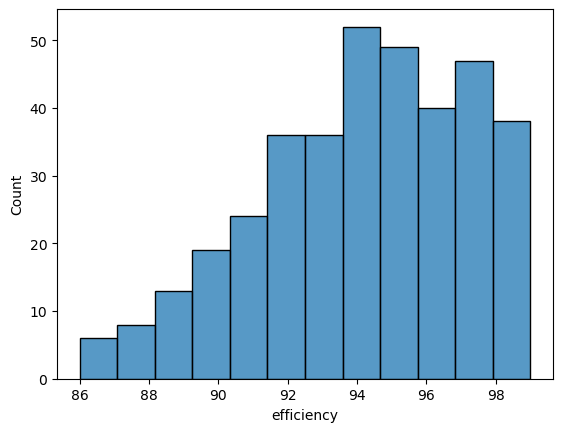

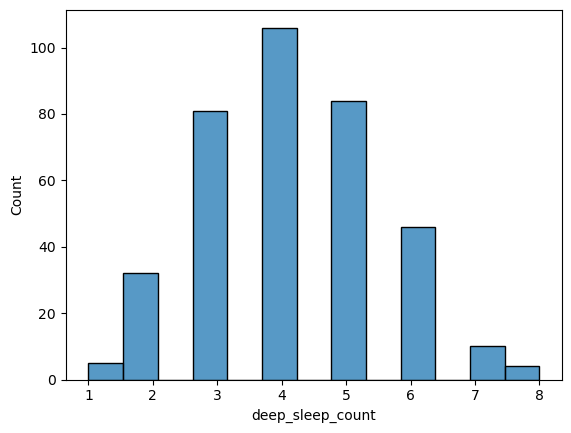

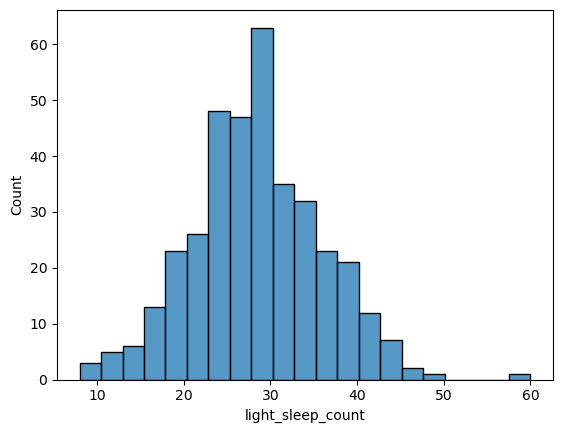

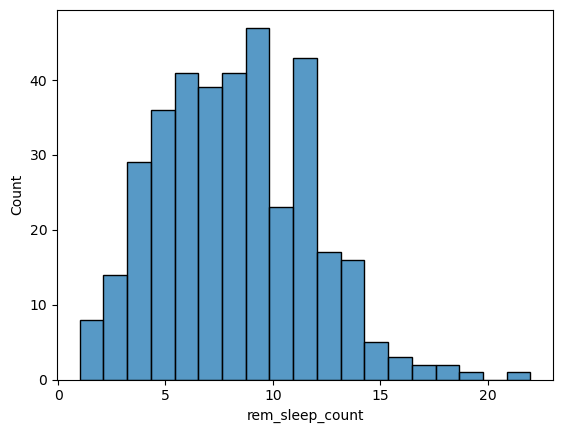

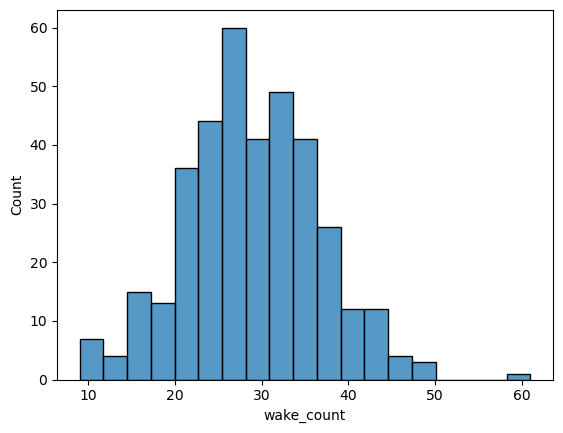

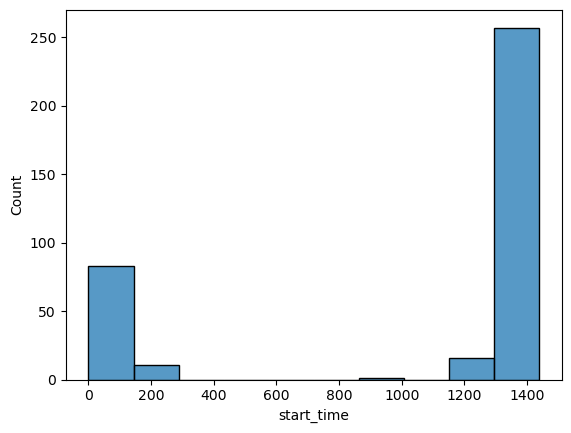

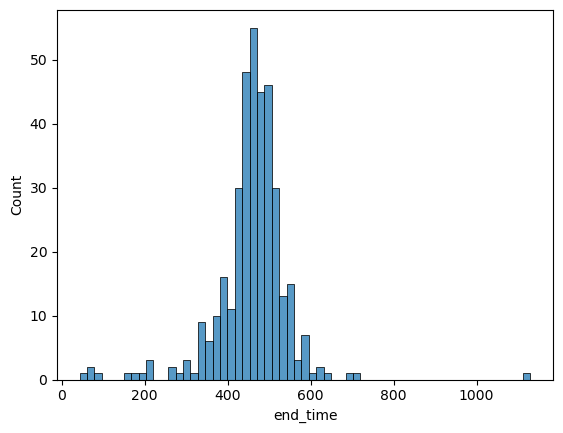

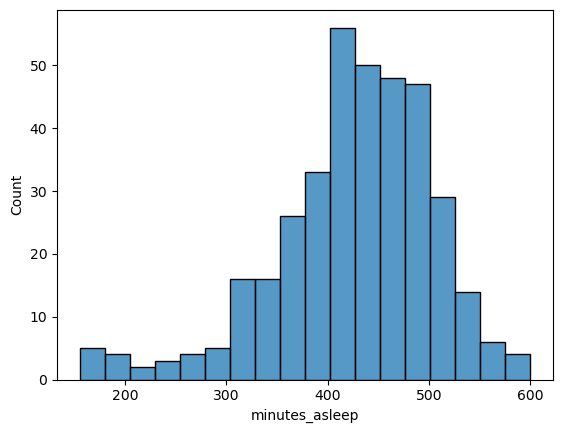

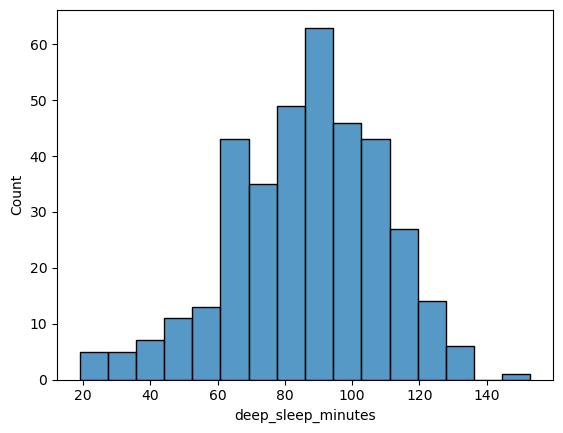

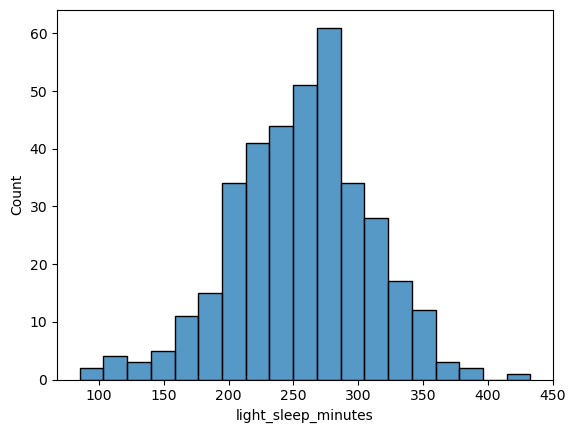

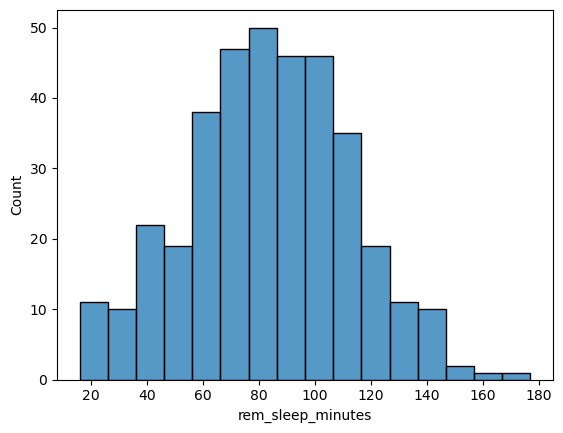

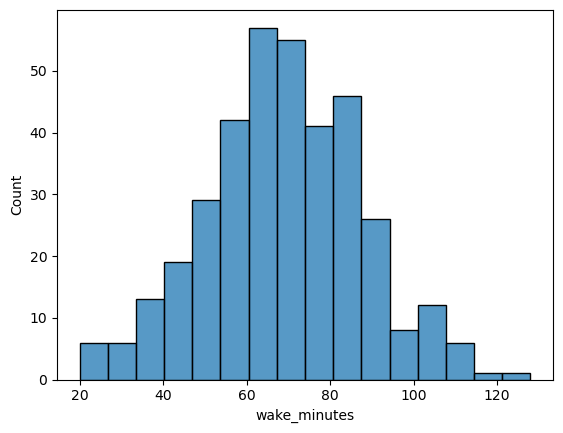

In [43]:
hist_cols = ['efficiency','deep_sleep_count','light_sleep_count','rem_sleep_count','wake_count','start_time','end_time','minutes_asleep','deep_sleep_minutes','light_sleep_minutes','rem_sleep_minutes','wake_minutes']

for col in hist_cols:
    sns.histplot(merged_df[col])
    plt.show()

In [44]:
merged_df.head()

,date,efficiency,start_time,end_time,time_in_bed,minutes_asleep,minutesToFallAsleep,minutes_awake,IsMainSleep,deep_sleep_count,deep_sleep_minutes,deep_sleep_30dayAvgMin,light_sleep_count,light_sleep_minutes,light_sleep_30dayAvgMin,rem_sleep_count,rem_sleep_minutes,rem_sleep_30dayAvgMin,wake_count,wake_minutes,wake_30dayAvgMin,Aerobic Workout_calorie_burn,Elliptical_calorie_burn,Run_calorie_burn,Sport_calorie_burn,Walk_calorie_burn,Aerobic Workout_original_duration,Elliptical_original_duration,Run_original_duration,Sport_original_duration,Walk_original_duration,is_nap
0,2023-02-21,94,1368,464,535,477,0,58,1,7.0,123.0,0.0,27.0,255.0,0.0,9.0,99.0,0.0,27.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2023-02-22,96,22,511,489,424,0,65,1,4.0,65.0,123.0,28.0,282.0,255.0,8.0,77.0,99.0,26.0,65.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2023-02-23,94,1427,420,433,361,0,72,1,5.0,98.0,94.0,20.0,166.0,269.0,6.0,97.0,88.0,20.0,72.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2023-02-24,95,1291,445,594,508,0,86,1,5.0,93.0,95.0,37.0,345.0,234.0,7.0,70.0,91.0,31.0,86.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2023-02-25,95,82,495,412,346,0,66,1,3.0,82.0,95.0,30.0,218.0,262.0,5.0,46.0,86.0,30.0,66.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Text(0.5, 1.0, 'start time vs minutes asleep')

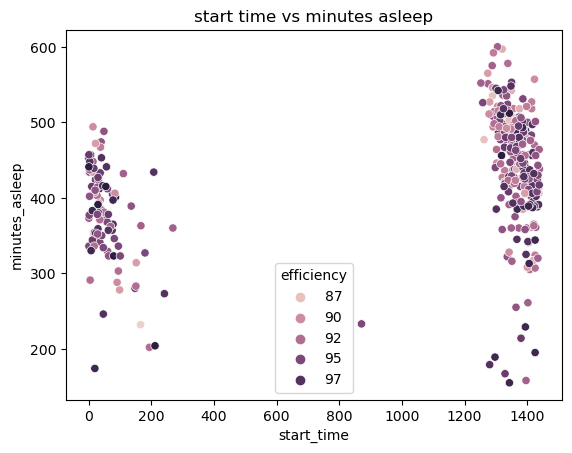

In [45]:
sns.scatterplot(data=merged_df,x='start_time',y='minutes_asleep',hue='efficiency')
plt.title('start time vs minutes asleep')

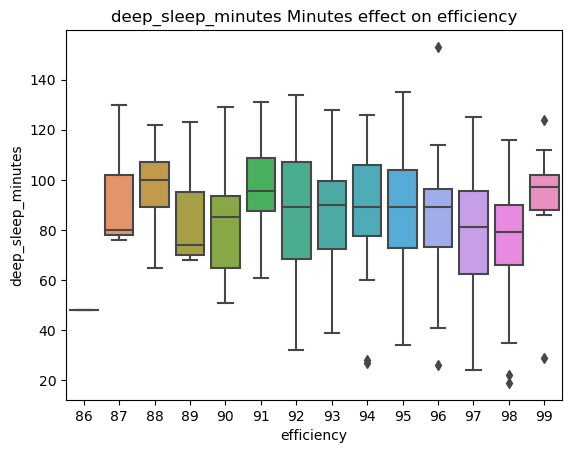

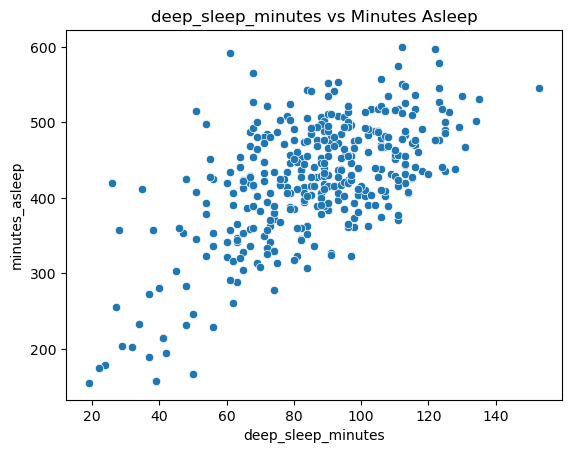

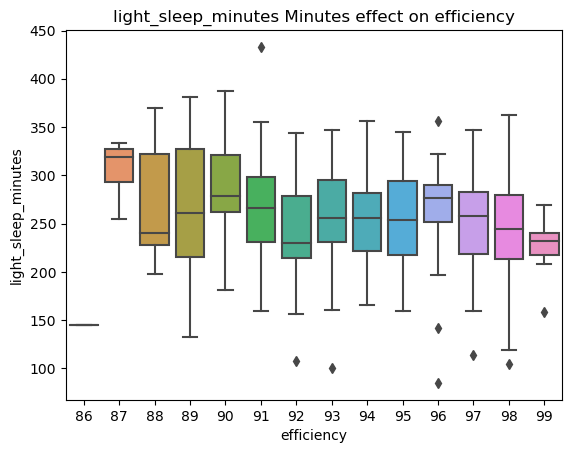

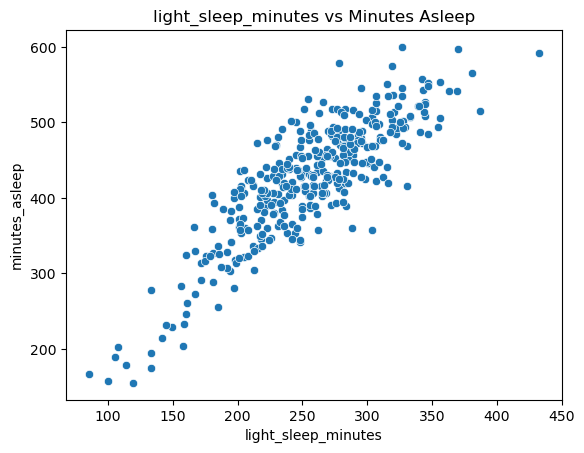

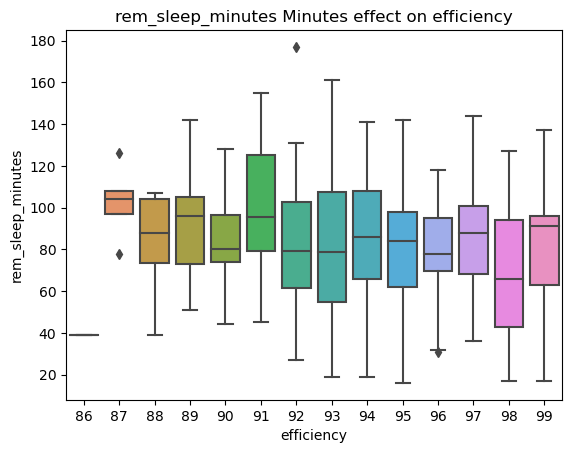

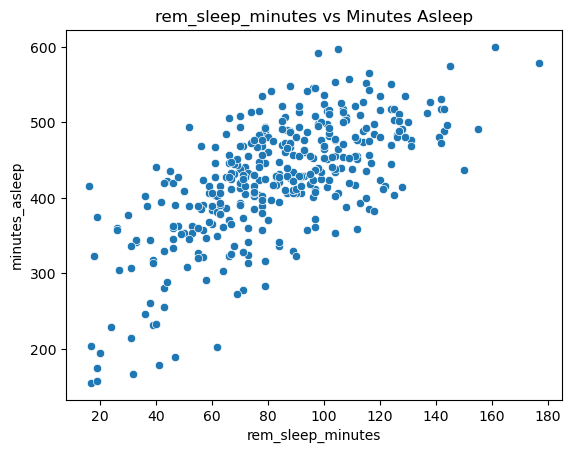

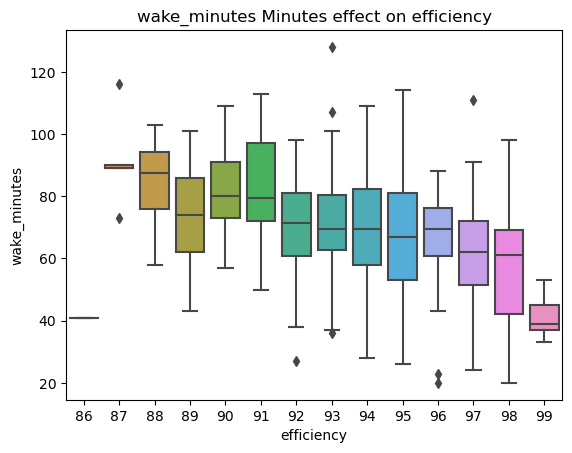

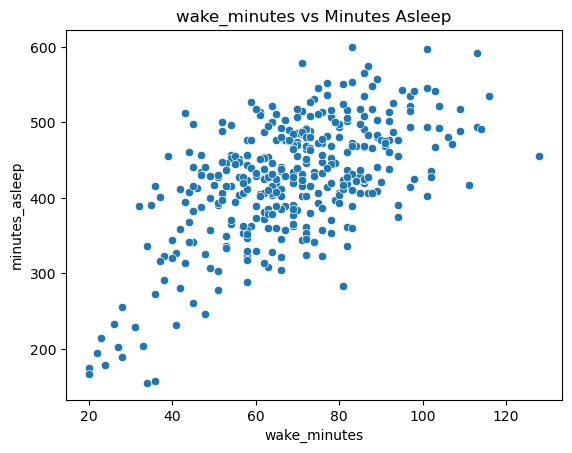

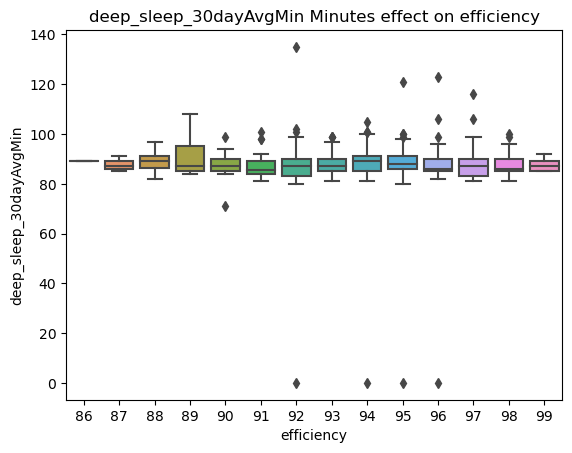

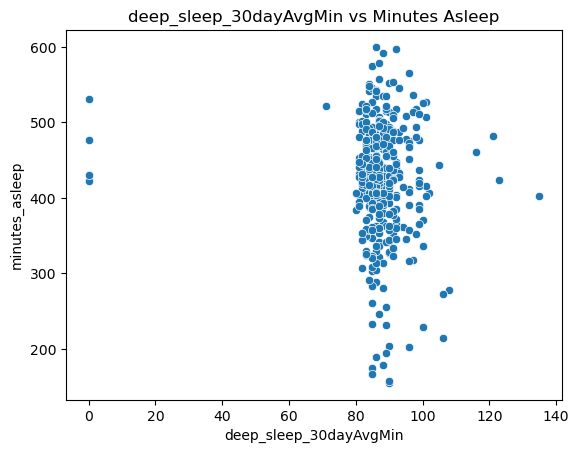

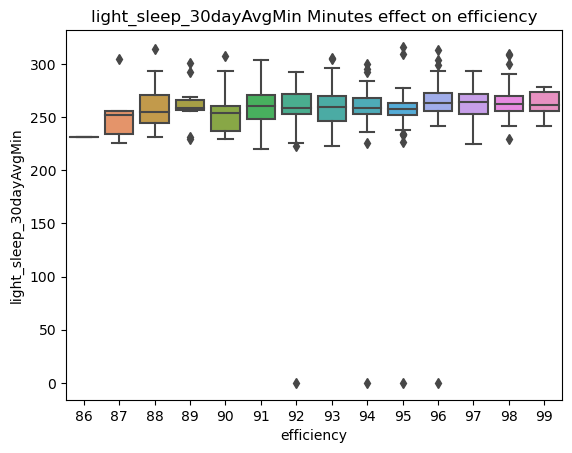

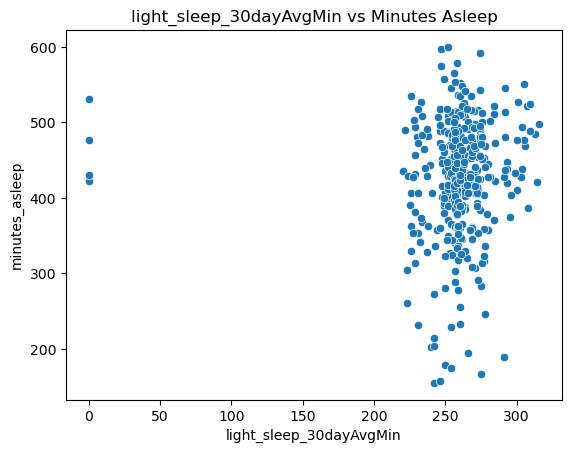

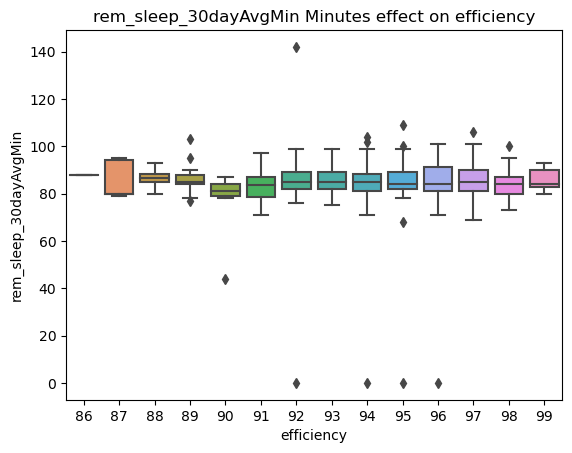

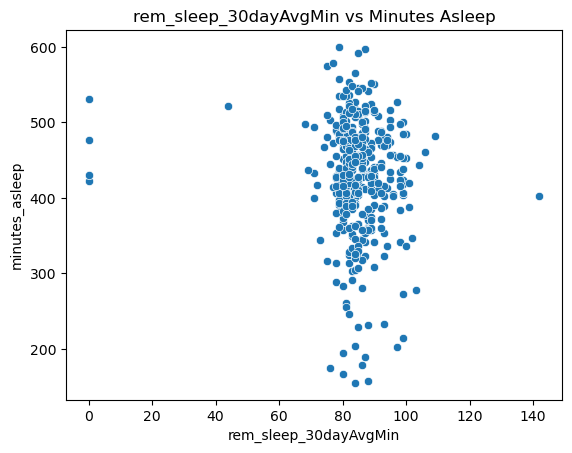

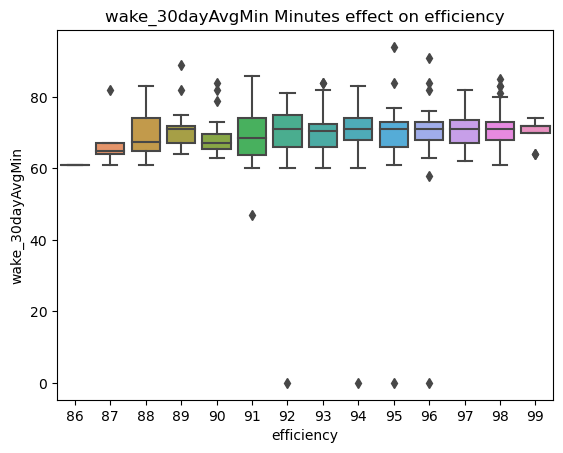

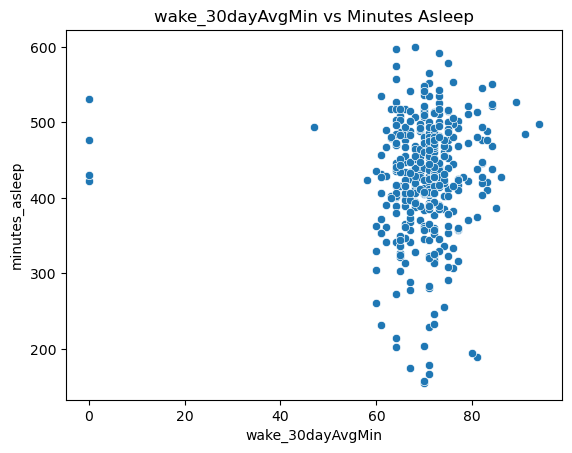

In [54]:
sleep_stages = ['deep_sleep_minutes','light_sleep_minutes','rem_sleep_minutes','wake_minutes','deep_sleep_30dayAvgMin','light_sleep_30dayAvgMin','rem_sleep_30dayAvgMin','wake_30dayAvgMin']

for stage in sleep_stages:
    sns.boxplot(data=merged_df,x='efficiency',y=stage)
    plt.title(f'{stage} Minutes effect on efficiency')
    plt.show()

    sns.scatterplot(data=merged_df,x=stage,y='minutes_asleep')
    plt.title(f'{stage} vs Minutes Asleep')
    plt.show()

<Axes: xlabel='efficiency', ylabel='minutes_asleep'>

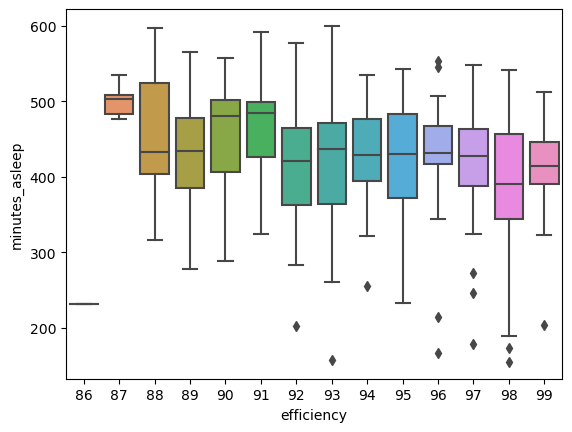

In [47]:
sns.boxplot(data=merged_df,x='efficiency',y='minutes_asleep')

In [50]:
merged_df.head()

,date,efficiency,start_time,end_time,time_in_bed,minutes_asleep,minutesToFallAsleep,minutes_awake,IsMainSleep,deep_sleep_count,deep_sleep_minutes,deep_sleep_30dayAvgMin,light_sleep_count,light_sleep_minutes,light_sleep_30dayAvgMin,rem_sleep_count,rem_sleep_minutes,rem_sleep_30dayAvgMin,wake_count,wake_minutes,wake_30dayAvgMin,Aerobic Workout_calorie_burn,Elliptical_calorie_burn,Run_calorie_burn,Sport_calorie_burn,Walk_calorie_burn,Aerobic Workout_original_duration,Elliptical_original_duration,Run_original_duration,Sport_original_duration,Walk_original_duration,is_nap
0,2023-02-21,94,1368,464,535,477,0,58,1,7.0,123.0,0.0,27.0,255.0,0.0,9.0,99.0,0.0,27.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2023-02-22,96,22,511,489,424,0,65,1,4.0,65.0,123.0,28.0,282.0,255.0,8.0,77.0,99.0,26.0,65.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2023-02-23,94,1427,420,433,361,0,72,1,5.0,98.0,94.0,20.0,166.0,269.0,6.0,97.0,88.0,20.0,72.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2023-02-24,95,1291,445,594,508,0,86,1,5.0,93.0,95.0,37.0,345.0,234.0,7.0,70.0,91.0,31.0,86.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2023-02-25,95,82,495,412,346,0,66,1,3.0,82.0,95.0,30.0,218.0,262.0,5.0,46.0,86.0,30.0,66.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


<Axes: xlabel='rem_sleep_minutes', ylabel='rem_sleep_30dayAvgMin'>

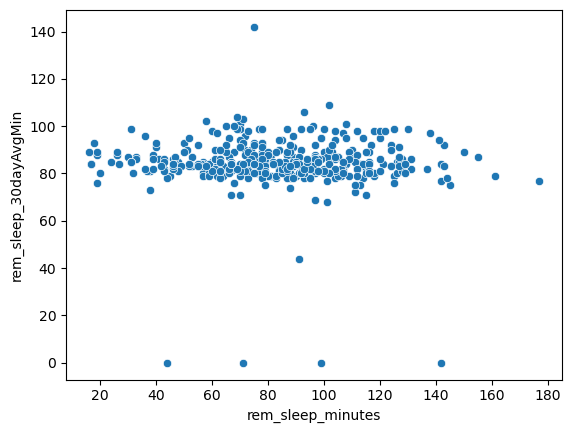

In [53]:
sns.scatterplot(data=merged_df,x='rem_sleep_minutes',y='rem_sleep_30dayAvgMin')

<Axes: >

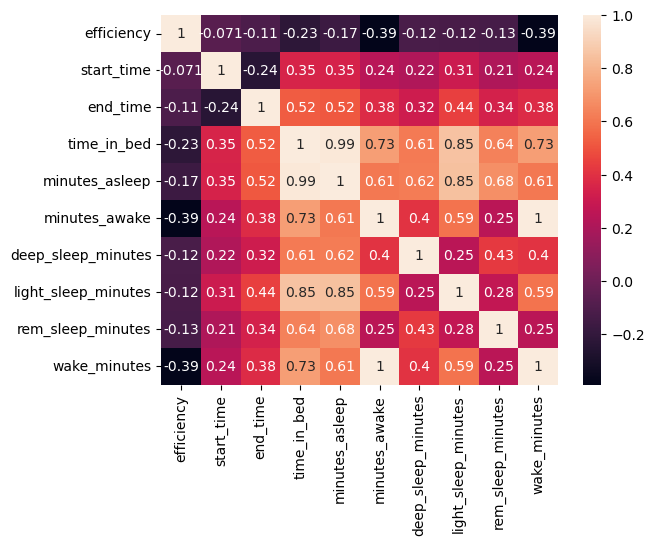

In [69]:
sns.heatmap(data=merged_df[['efficiency','start_time','end_time','time_in_bed','minutes_asleep','minutes_awake','deep_sleep_minutes','light_sleep_minutes','rem_sleep_minutes','wake_minutes']].corr(),annot=True)

In [56]:
merged_df.columns

Index(['date', 'efficiency', 'start_time', 'end_time', 'time_in_bed',
       'minutes_asleep', 'minutesToFallAsleep', 'minutes_awake', 'IsMainSleep',
       'deep_sleep_count', 'deep_sleep_minutes', 'deep_sleep_30dayAvgMin',
       'light_sleep_count', 'light_sleep_minutes', 'light_sleep_30dayAvgMin',
       'rem_sleep_count', 'rem_sleep_minutes', 'rem_sleep_30dayAvgMin',
       'wake_count', 'wake_minutes', 'wake_30dayAvgMin',
       'Aerobic Workout_calorie_burn', 'Elliptical_calorie_burn',
       'Run_calorie_burn', 'Sport_calorie_burn', 'Walk_calorie_burn',
       'Aerobic Workout_original_duration', 'Elliptical_original_duration',
       'Run_original_duration', 'Sport_original_duration',
       'Walk_original_duration', 'is_nap'],
      dtype='object')

<Axes: >

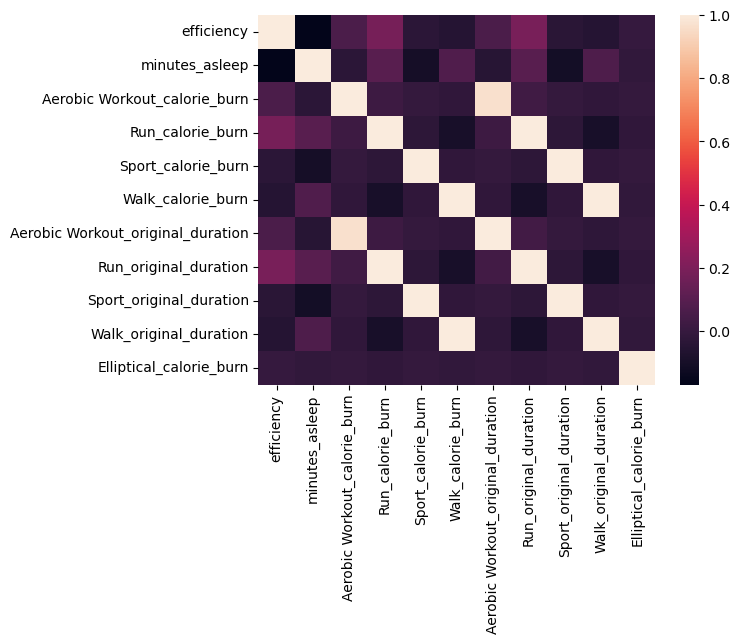

In [71]:
sns.heatmap(data=merged_df[['efficiency','minutes_asleep','Aerobic Workout_calorie_burn','Run_calorie_burn','Sport_calorie_burn','Walk_calorie_burn','Aerobic Workout_original_duration','Run_original_duration','Sport_original_duration','Walk_original_duration','Elliptical_calorie_burn']].corr())

In [91]:
merged_df.columns

Index(['date', 'efficiency', 'start_time', 'end_time', 'time_in_bed',
       'minutes_asleep', 'minutesToFallAsleep', 'minutes_awake', 'IsMainSleep',
       'deep_sleep_count', 'deep_sleep_minutes', 'deep_sleep_30dayAvgMin',
       'light_sleep_count', 'light_sleep_minutes', 'light_sleep_30dayAvgMin',
       'rem_sleep_count', 'rem_sleep_minutes', 'rem_sleep_30dayAvgMin',
       'wake_count', 'wake_minutes', 'wake_30dayAvgMin',
       'Aerobic Workout_calorie_burn', 'Elliptical_calorie_burn',
       'Run_calorie_burn', 'Sport_calorie_burn', 'Walk_calorie_burn',
       'Aerobic Workout_original_duration', 'Elliptical_original_duration',
       'Run_original_duration', 'Sport_original_duration',
       'Walk_original_duration', 'is_nap'],
      dtype='object')

In [99]:
X = np.array(merged_df[['Walk_original_duration','Sport_original_duration','Run_original_duration','Aerobic Workout_original_duration','Walk_calorie_burn','Sport_calorie_burn','Run_calorie_burn','Aerobic Workout_calorie_burn','start_time']])
y = merged_df['minutes_asleep']

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [101]:
model = LinearRegression()


In [102]:
model.fit(X_train, y_train)


LinearRegression()

In [103]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 5141.273488667755
R-squared: -0.006029852201367536


In [104]:
rf = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=4, random_state=42)

In [105]:
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 5060.227799366267
R-squared: 0.00982893901237547
